In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import numpy as np

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Select bus trip data and merge with weather information

In [3]:
#function to open temperature dataset
def temp(path_tem =r'/content/drive/My Drive/Colab Notebooks/Thesis/temperature' ):
  #path_tem =r'/content/drive/My Drive/Colab Notebooks/Thesis/temperature' # use your path
  allFiles = glob.glob(path_tem + "/*.txt")

  list_ = []
  i=0


  for file_ in allFiles:
      df = pd.read_csv(file_, sep=';',skiprows=1,
                        names = ['STATIONS_ID','MESS_DATUM','QN_8','R1','Precipitation','WRTR','eor'
                                ])
      #df['date'] = date_list[i]
      #df['line'] = line_list[i]

      #df = restructure_data(df)
      list_.append(df)
      i+=1

  Ta_list = pd.concat(list_, axis = 0, ignore_index = True)
  Ta_list = Ta_list.drop(['STATIONS_ID','QN_8','WRTR', 'eor'], axis=1)
  Ta_list['date_time'] = pd.to_datetime(Ta_list.MESS_DATUM, format='%Y%m%d%H', errors='ignore')
  Ta_list= Ta_list.groupby(['date_time'], as_index=False).mean()
  Ta_list['Precipitation'] = np.ceil(Ta_list.Precipitation)
  return Ta_list

In [4]:
file_name = 112 # or 4

if file_name == 112: #the whole year 2019
  path = "/content/drive/My Drive/Colab Notebooks/Thesis/IST_filter_Line28.csv"
  df = pd.read_csv(path)
  df = df.drop(['index'], axis=1)
  df['Ab_ZT_PLAN'] = df['Ab_ZT_PLAN'].astype('datetime64[ns]')
  df['Ank_ZT_PLAN'] = df['Ank_ZT_PLAN'].astype('datetime64[ns]')
  df['TagMean'] = df['Ab_ZT_PLAN']+(df['Ank_ZT_PLAN']-df['Ab_ZT_PLAN'])/2
  df['TagRound'] = df['TagMean'].dt.round("H")
  df['TagRound'] = df['TagRound'].astype('datetime64[ns]')

  Ta_list = temp()

  dft_join = pd.merge(df, Ta_list, how='left', left_on=['TagRound'], right_on = ['date_time'])
  dft_join = dft_join.drop('date_time', axis = 1)
  
  df_filter = dft_join.copy()
elif file_name == 4: #only April
  path = "/content/drive/My Drive/Colab Notebooks/Thesis/IST_ECR_filter_0419.csv"
  df_filter = pd.read_csv(path)

# **Having a quick look at the data**

In [5]:
#df_filter = df_filter.drop(['Unnamed: 0','index'], axis=1)
df_filter.tail() #[-50:]

,Unnamed: 0,Datum,UML,Wagen,Ab_ZT_PLAN,Linie,Haltestelle,Fahrplanlage_IST,v_PLAN,v_IST_S2S1,v_netto_S2S1,FFVP_GESCHWINDIGKEIT,v_IST,Ank_ZT_PLAN,S_Station,E_Station,NHaltestelle,Node A to Node B,date,Ab_ZT_ACTUAL,Ank_ZT_ACTUAL,Driving_time_s,Distance_m,Driving_time_s_p,Distance_m_p,TagMean,TagRound,MESS_DATUM,R1,Precipitation
673736,673736,24.10.2019,77200.0,1612.0,2019-10-24 18:53:00,28.0,U Habichtstraße,14.7,19.8,4.7,3.8,0,4.1,2019-10-24 18:54:00,S Rübenkamp,Wandsbeker Allee,Habichtstraße (Mitte),U Habichtstraße|Habichtstraße (Mitte),24.10.2019,2019-10-24 19:07:42,2019-10-24 19:12:18,276.0,314.333333,60.0,330.000000,2019-10-24 18:53:30,2019-10-24 19:00:00,2.019102e+09,0.0,0.0
673737,673737,24.10.2019,77200.0,1612.0,2019-10-24 18:54:00,28.0,Habichtstraße (Mitte),18.3,16.1,7.4,6.9,0,6.7,2019-10-24 18:57:00,S Rübenkamp,Wandsbeker Allee,U Alter Teichweg,Habichtstraße (Mitte)|U Alter Teichweg,24.10.2019,2019-10-24 19:12:18,2019-10-24 19:19:42,444.0,826.333333,180.0,805.000000,2019-10-24 18:55:30,2019-10-24 19:00:00,2.019102e+09,0.0,0.0
673738,673738,24.10.2019,77200.0,1612.0,2019-10-24 18:57:00,28.0,U Alter Teichweg,22.7,20.9,8.6,6.8,0,6.9,2019-10-24 18:59:00,S Rübenkamp,Wandsbeker Allee,U Straßburger Straße,U Alter Teichweg|U Straßburger Straße,24.10.2019,2019-10-24 19:19:42,2019-10-24 19:25:30,348.0,667.000000,120.0,696.666667,2019-10-24 18:58:00,2019-10-24 19:00:00,2.019102e+09,0.0,0.0
673739,673739,24.10.2019,77200.0,1612.0,2019-10-24 18:59:00,28.0,U Straßburger Straße,26.5,18.1,-,-,19,11.9,2019-10-24 19:00:00,S Rübenkamp,Wandsbeker Allee,Wandsbeker Allee,U Straßburger Straße|Wandsbeker Allee,24.10.2019,2019-10-24 19:25:30,2019-10-24 19:27:00,90.0,297.500000,60.0,301.666667,2019-10-24 18:59:30,2019-10-24 19:00:00,2.019102e+09,0.0,0.0
673740,673740,24.10.2019,77200.0,1612.0,2019-10-24 19:00:00,28.0,Wandsbeker Allee,27.0,19.4,-,-,34,-,2019-10-24 12:47:00,S Rübenkamp,Wandsbeker Allee,Source,Wandsbeker Allee|Source,24.10.2019,2019-10-24 19:27:00,2019-10-24 12:47:42,-23958.0,NaN,-22380.0,-120603.333333,2019-10-24 15:53:30,2019-10-24 16:00:00,2.019102e+09,0.0,0.0


In [6]:
# Checking how many unique lines there are in the dataframe
len(df_filter.Linie.unique())

1

In [7]:
df_filter.dtypes

Unnamed: 0                       int64
Datum                           object
UML                            float64
Wagen                          float64
Ab_ZT_PLAN              datetime64[ns]
Linie                          float64
Haltestelle                     object
Fahrplanlage_IST               float64
v_PLAN                         float64
v_IST_S2S1                      object
v_netto_S2S1                    object
FFVP_GESCHWINDIGKEIT            object
v_IST                           object
Ank_ZT_PLAN             datetime64[ns]
S_Station                       object
E_Station                       object
NHaltestelle                    object
Node A to Node B                object
date                            object
Ab_ZT_ACTUAL                    object
Ank_ZT_ACTUAL                   object
Driving_time_s                 float64
Distance_m                     float64
Driving_time_s_p               float64
Distance_m_p                   float64
TagMean                 d

In [8]:
df_filter['date']= pd.to_datetime(df_filter.date, format='%d.%m.%Y', errors='ignore') #change date format
#df_filter.head()

In [9]:
df_filter = df_filter.sort_values( ['date', 'Unnamed: 0']).reset_index(drop = True) #
#df_filter.tail() #[-50:]

# **Select only relevent features**

Features are selected based on Chen et al.(2004) paper.

## Journey 101 ***U Wandsbek Markt to S Rübenkamp***

In [10]:
df_selected = df_filter.loc[df_filter['S_Station'] == 'U Wandsbek Markt'].reset_index()
df_selected = df_selected.loc[df_selected['E_Station'] == 'S Rübenkamp'].reset_index()
df_selected = df_selected[['Ab_ZT_PLAN', 'TagRound', 'UML', 'Linie', 'Node A to Node B', 'Precipitation', 'Driving_time_s_p', 'Driving_time_s']]
#df_selected = df_selected.loc[df_selected['UML'] == 77082]
df_selected = df_selected.loc[df_selected['Linie']  == 28].reset_index()
df_selected = df_selected.loc[(df_selected['Driving_time_s']  <= 1000) & (df_selected['Driving_time_s']  >= 0)].reset_index()
df_selected = df_selected.drop(['Linie', 'TagRound', 'index', 'UML', 'level_0'], axis=1)

In [11]:
df_selected= df_selected.rename({'Ab_ZT_PLAN': 'Time'}, axis=1)

In [12]:
#df_selected

In [13]:
import math
df_selected['dayofweek'] = df_selected['Time'].dt.dayofweek
df_selected['hour'] = (df_selected['Time'].dt.hour+1)
df_selected['day'] = df_selected['Time'].dt.day
df_selected['month'] = df_selected['Time'].dt.month
df_selected['timeofday'] = [0 for number in df_selected['Time']]
#df_selected

Filter Holidays out

In [14]:
#df_selected = df_selected[~df_selected['day'].isin([19,22])].reset_index() # for April dataset
df_selected = df_selected.loc[~(((df_selected['day'] == 1) & (df_selected['month'] ==  1)) # for the whole year dataset
                  |((df_selected['day'] == 19) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 21) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 22) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 1) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 30) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 10) & (df_selected['month'] == 6))
                  |((df_selected['day'] == 3) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 31) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 25) & (df_selected['month'] == 12))
                  |((df_selected['day'] == 26) & (df_selected['month'] == 12))
                  ),:].reset_index()
df_selected.tail() #[:50]

,index,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,hour,day,month,timeofday
133269,136831,2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1.0,180.0,144.0,0,9,23,12,0
133270,136832,2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1.0,60.0,66.0,0,10,23,12,0
133271,136833,2019-12-23 09:02:00,Hartzloh|AK Barmbek,1.0,60.0,60.0,0,10,23,12,0
133272,136834,2019-12-23 09:03:00,AK Barmbek|Hebebrandstraße,1.0,120.0,132.0,0,10,23,12,0
133273,136835,2019-12-23 09:05:00,Hebebrandstraße|S Rübenkamp,1.0,120.0,60.0,0,10,23,12,0


Find high driving time period on day

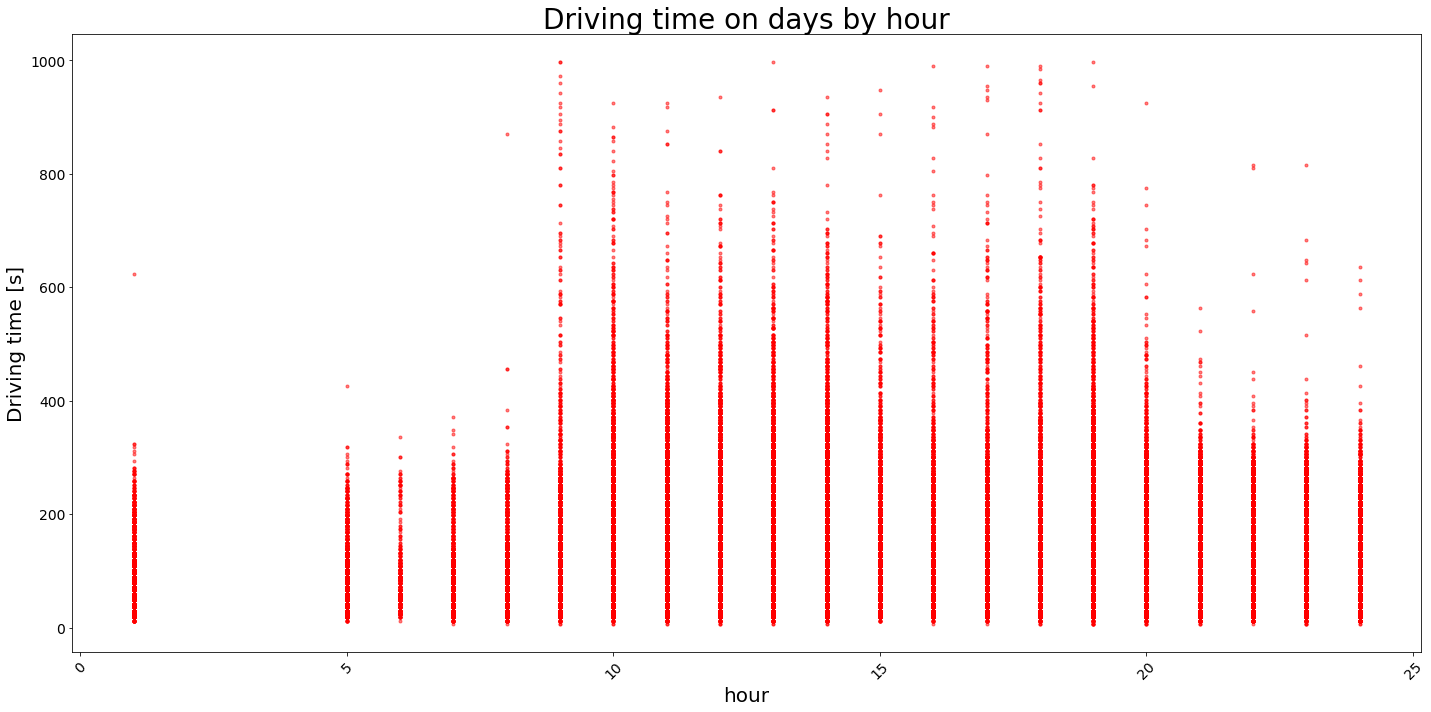

In [15]:
plt.figure(figsize=(20,10))

plt.plot(df_selected['hour'], df_selected['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('hour', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time on days by hour', fontsize=28)

plt.tight_layout()

In [16]:
# manual clustering the hour
for i in range(len(df_selected)):
  #print('1')
  if df_selected['hour'][i]<9:
    df_selected['timeofday'][i] = 0
  elif df_selected['hour'][i]<11:
    df_selected['timeofday'][i] = 1
  elif df_selected['hour'][i] < 16:
    df_selected['timeofday'][i] = 2
  elif df_selected['hour'][i] <20:
    df_selected['timeofday'][i] = 3
  else:
    df_selected['timeofday'][i] = 4

#df_selected


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib

In [17]:
df_selected = df_selected.drop(['index','day','hour'], axis=1)
df_selected

,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday
0,2019-01-02 09:47:00,U Wandsbek Markt|Wandsbeker Allee,0.0,180.0,204.0,2,1,1
1,2019-01-02 09:50:00,Wandsbeker Allee|U Straßburger Straße,0.0,120.0,108.0,2,1,1
2,2019-01-02 09:52:00,U Straßburger Straße|U Alter Teichweg,0.0,120.0,96.0,2,1,1
3,2019-01-02 09:54:00,U Alter Teichweg|Habichtstraße (Mitte),0.0,180.0,168.0,2,1,1
4,2019-01-02 09:57:00,Habichtstraße (Mitte)|U Habichtstraße,0.0,60.0,54.0,2,1,1
...,...,...,...,...,...,...,...,...
133269,2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1.0,180.0,144.0,0,12,1
133270,2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1.0,60.0,66.0,0,12,1
133271,2019-12-23 09:02:00,Hartzloh|AK Barmbek,1.0,60.0,60.0,0,12,1
133272,2019-12-23 09:03:00,AK Barmbek|Hebebrandstraße,1.0,120.0,132.0,0,12,1


In [18]:
len(df_selected['Node A to Node B'].unique())

29

In [19]:
df_selected.describe()

,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday
count,133274.000000,133274.000000,133274.000000,133274.000000,133274.000000,133274.000000
mean,-0.260103,100.369014,107.076729,3.573608,6.398165,2.623332
std,16.747740,57.641203,90.010200,1.997125,3.273029,1.237864
min,-499.000000,60.000000,6.000000,0.000000,1.000000,0.000000
25%,0.000000,60.000000,54.000000,2.000000,4.000000,2.000000
50%,0.000000,120.000000,78.000000,4.000000,6.000000,3.000000
75%,1.000000,120.000000,126.000000,5.000000,9.000000,4.000000
max,1.000000,3480.000000,996.000000,6.000000,12.000000,4.000000


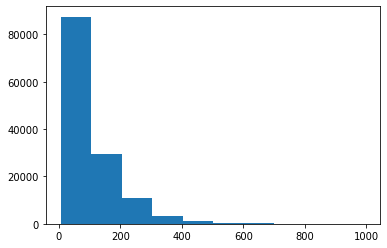

In [20]:
plt.hist(df_selected['Driving_time_s'])
plt.show()

In [21]:
data = df_selected.copy()

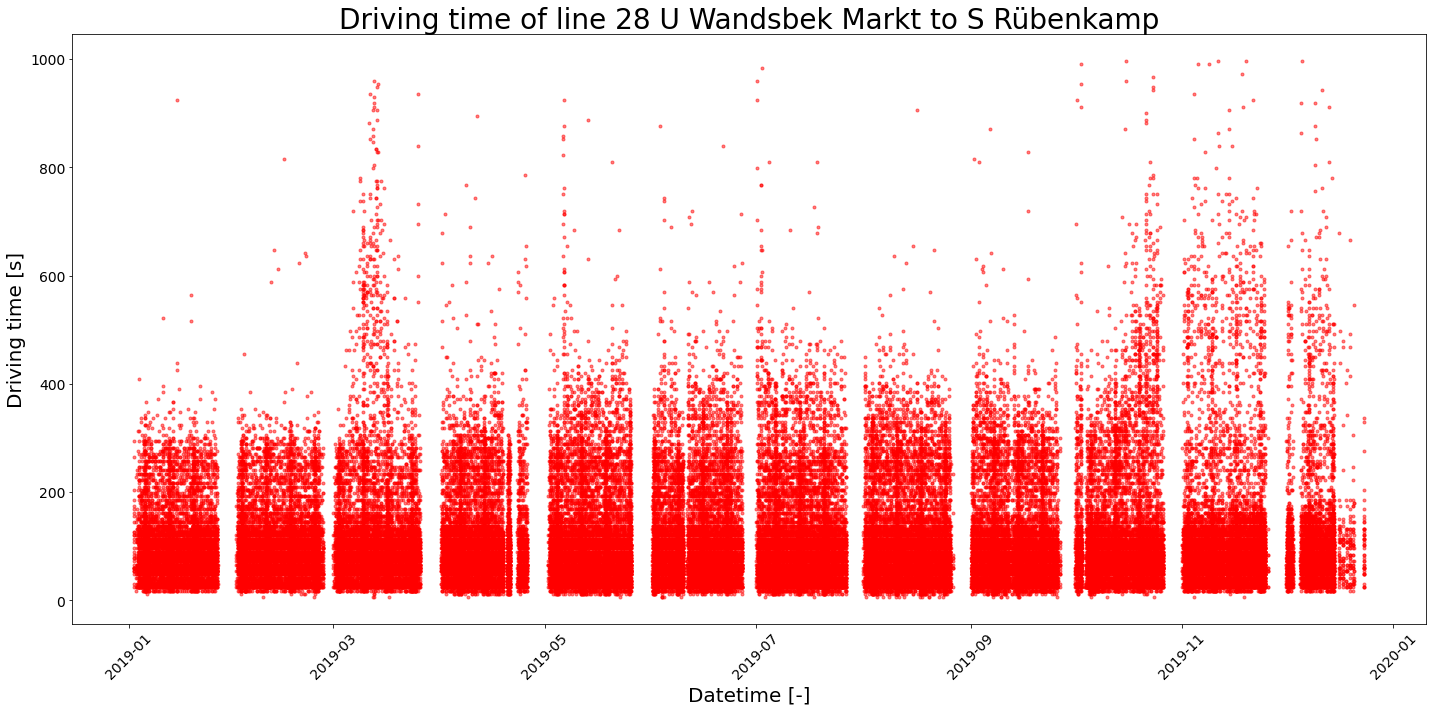

In [22]:
plt.figure(figsize=(20,10))

plt.plot(data['Time'], data['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time of line 28 U Wandsbek Markt to S Rübenkamp', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

From this plot it is clear that the driving time is really fluctuate. The highest one is almost 4000 second.
There are periods of missing data visible on every weekend.

**Add two new columns for accumulate values**

In [23]:
data.loc[data.Precipitation == -499 ]=0
data = data.loc[data['Node A to Node B'].isin(['U Wandsbek Markt|Wandsbeker Allee',
       'Wandsbeker Allee|U Straßburger Straße',
       'U Straßburger Straße|U Alter Teichweg',
       'U Alter Teichweg|Habichtstraße (Mitte)',
       'Habichtstraße (Mitte)|U Habichtstraße',
       'U Habichtstraße|Habichtsplatz', 'Habichtsplatz|Neue Wöhr',
       'Neue Wöhr|Hartzloh', 'Hartzloh|AK Barmbek',
       'AK Barmbek|Hebebrandstraße', 'Hebebrandstraße|S Rübenkamp'])]

In [24]:
data =data.reset_index(drop=True)

In [25]:
route_unique = (data['Node A to Node B'].unique())
route_unique

array(['U Wandsbek Markt|Wandsbeker Allee',
       'Wandsbeker Allee|U Straßburger Straße',
       'U Straßburger Straße|U Alter Teichweg',
       'U Alter Teichweg|Habichtstraße (Mitte)',
       'Habichtstraße (Mitte)|U Habichtstraße',
       'U Habichtstraße|Habichtsplatz', 'Habichtsplatz|Neue Wöhr',
       'Neue Wöhr|Hartzloh', 'Hartzloh|AK Barmbek',
       'AK Barmbek|Hebebrandstraße', 'Hebebrandstraße|S Rübenkamp'],
      dtype=object)

In [26]:
#act_p = []
data['Actual_trip_cum'] = 0
data['Planned_trip_cum'] = 0
a = 0
b = 0

for i in range(len(data)):
  #print(i)
  if data['Node A to Node B'][i] == route_unique[0]: #the first path
    a = data['Driving_time_s'][i]
    data['Actual_trip_cum'][i] = a
    b = data['Driving_time_s_p'][i]
    data['Planned_trip_cum'][i] = b
  else:
    a += data['Driving_time_s'][i] 
    data['Actual_trip_cum'][i] = a
    b += data['Driving_time_s_p'][i]
    data['Planned_trip_cum'][i] = b
data.tail() #[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/loc

,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday,Actual_trip_cum,Planned_trip_cum
132959,2019-12-23 08:58:00,Habichtsplatz|Neue Wöhr,1.0,180.0,144.0,0,12,1,864,900
132960,2019-12-23 09:01:00,Neue Wöhr|Hartzloh,1.0,60.0,66.0,0,12,1,930,960
132961,2019-12-23 09:02:00,Hartzloh|AK Barmbek,1.0,60.0,60.0,0,12,1,990,1020
132962,2019-12-23 09:03:00,AK Barmbek|Hebebrandstraße,1.0,120.0,132.0,0,12,1,1122,1140
132963,2019-12-23 09:05:00,Hebebrandstraße|S Rübenkamp,1.0,120.0,60.0,0,12,1,1182,1260


In [27]:
#data = data.loc[data.month<3]

In [28]:
#data.to_csv('ist_0420_data_processed.csv')
#!cp ist_0420_data_processed.csv "/content/drive/My Drive/Colab Notebooks/Thesis"
data.to_csv('ist_01_12_19_data_processed.csv')
!cp ist_01_12_19_data_processed.csv "/content/drive/My Drive/Colab Notebooks/Thesis"



---
Same procedure implement on other journeys.



## Journey 102 ***S Rübenkamp to U Wandsbek Markt***

In [29]:
df_selected = df_filter.loc[df_filter['S_Station'] == 'S Rübenkamp'].reset_index()
df_selected = df_selected.loc[df_selected['E_Station'] == 'U Wandsbek Markt'].reset_index()
df_selected = df_selected[['Ab_ZT_PLAN', 'TagRound', 'UML', 'Linie', 'Node A to Node B', 'Precipitation', 'Driving_time_s_p', 'Driving_time_s']]
#df_selected = df_selected.loc[df_selected['UML'] == 77082]
df_selected = df_selected.loc[df_selected['Linie']  == 28].reset_index()
df_selected = df_selected.loc[(df_selected['Driving_time_s']  <= 1000) & (df_selected['Driving_time_s']  >= 0)].reset_index()
df_selected = df_selected.drop(['Linie', 'TagRound', 'index', 'UML', 'level_0'], axis=1)
df_selected= df_selected.rename({'Ab_ZT_PLAN': 'Time'}, axis=1)

In [30]:
import math
df_selected['dayofweek'] = df_selected['Time'].dt.dayofweek
df_selected['hour'] = (df_selected['Time'].dt.hour+1)
df_selected['day'] = df_selected['Time'].dt.day
df_selected['month'] = df_selected['Time'].dt.month
df_selected['timeofday'] = [0 for number in df_selected['Time']]
df_selected

,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,hour,day,month,timeofday
0,2019-01-01 15:05:00,S Rübenkamp|AK Barmbek,1.0,180.0,198.0,1,16,1,1,0
1,2019-01-01 15:08:00,AK Barmbek|Hartzloh,1.0,120.0,96.0,1,16,1,1,0
2,2019-01-01 15:10:00,Hartzloh|Habichtsplatz,1.0,120.0,162.0,1,16,1,1,0
3,2019-01-01 15:12:00,Habichtsplatz|U Habichtstraße,1.0,60.0,84.0,1,16,1,1,0
4,2019-01-01 15:13:00,U Habichtstraße|Habichtstraße (Mitte),1.0,120.0,108.0,1,16,1,1,0
...,...,...,...,...,...,...,...,...,...,...
67672,2019-12-14 18:21:00,U Habichtstraße|Habichtstraße (Mitte),0.0,120.0,42.0,5,19,14,12,0
67673,2019-12-14 18:23:00,Habichtstraße (Mitte)|U Alter Teichweg,0.0,180.0,132.0,5,19,14,12,0
67674,2019-12-14 18:26:00,U Alter Teichweg|U Straßburger Straße,0.0,120.0,408.0,5,19,14,12,0
67675,2019-12-14 18:28:00,U Straßburger Straße|Wandsbeker Allee,0.0,60.0,102.0,5,19,14,12,0


Filter Holidays out, 19 and 22

In [31]:
#df_selected = df_selected[~df_selected['day'].isin([19,22])].reset_index()
df_selected = df_selected.loc[~(((df_selected['day'] == 1) & (df_selected['month'] ==  1))
                  |((df_selected['day'] == 19) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 21) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 22) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 1) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 30) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 10) & (df_selected['month'] == 6))
                  |((df_selected['day'] == 3) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 31) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 25) & (df_selected['month'] == 12))
                  |((df_selected['day'] == 26) & (df_selected['month'] == 12))
                  ),:].reset_index()
#df_selected.tail() #[:50]

Find driving time pattern to define peak hours

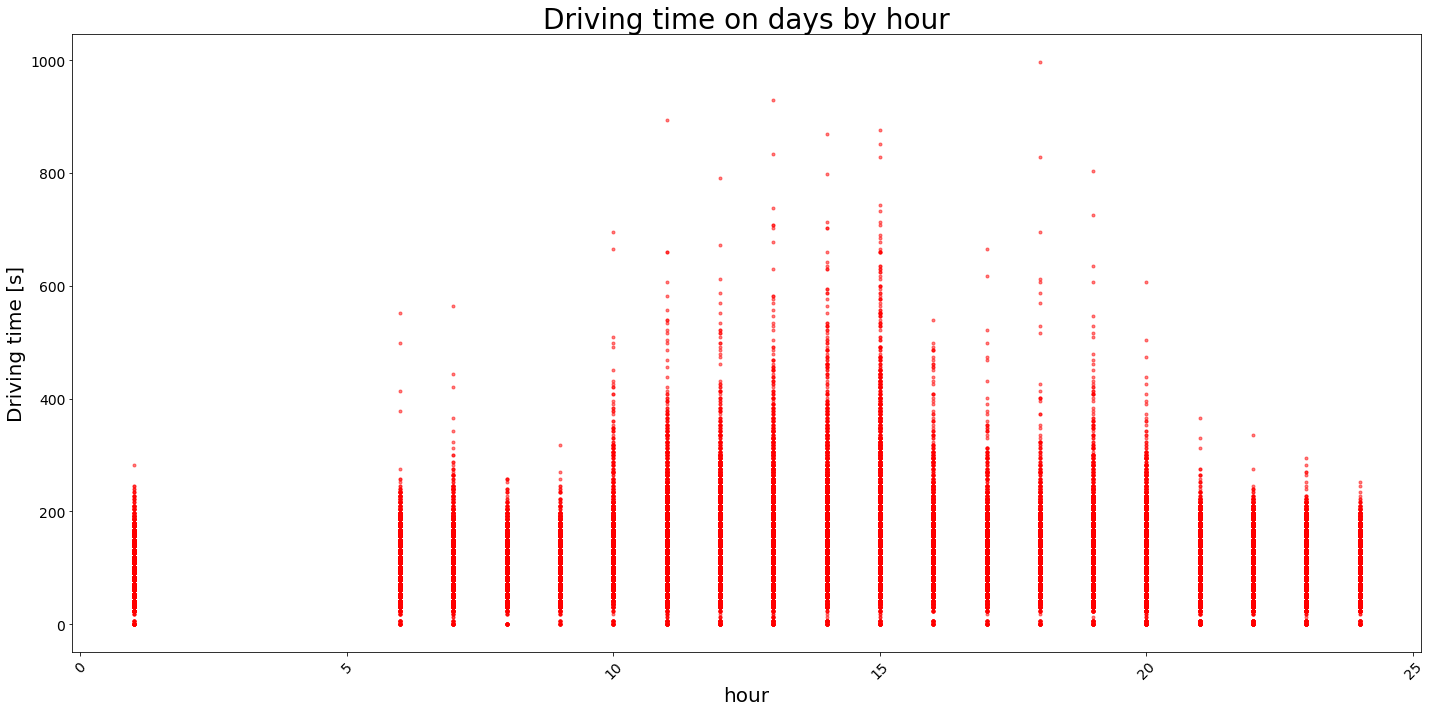

In [32]:
plt.figure(figsize=(20,10))

plt.plot(df_selected['hour'], df_selected['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('hour', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time on days by hour', fontsize=28)

plt.tight_layout()

In [33]:
for i in range(len(df_selected)):
  #print('1')
  if df_selected['hour'][i]<10:
    df_selected['timeofday'][i] = 0
  elif df_selected['hour'][i]<16:
    df_selected['timeofday'][i] = 1
  elif df_selected['hour'][i] < 18:
    df_selected['timeofday'][i] = 2
  elif df_selected['hour'][i] <21:
    df_selected['timeofday'][i] = 3
  else:
    df_selected['timeofday'][i] = 4

#df_selected

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykerne

In [34]:
df_selected = df_selected.drop(['index','day','hour'], axis=1)
#df_selected

In [35]:
len(df_selected['Node A to Node B'].unique())

15

In [36]:
df_selected.describe()

,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday
count,65563.000000,65563.000000,65563.000000,65563.000000,65563.000000,65563.00000
mean,-0.624758,115.597212,120.215609,3.677226,4.881046,1.99126
std,21.256677,58.405635,67.468726,1.980093,2.503362,1.47269
min,-499.000000,60.000000,0.000000,0.000000,1.000000,0.00000
25%,0.000000,60.000000,72.000000,2.000000,3.000000,1.00000
50%,0.000000,120.000000,108.000000,4.000000,5.000000,1.00000
75%,1.000000,120.000000,156.000000,5.000000,7.000000,4.00000
max,1.000000,480.000000,996.000000,6.000000,12.000000,4.00000


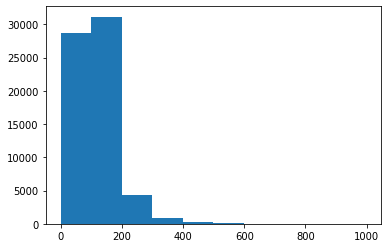

In [37]:
plt.hist(df_selected['Driving_time_s'])
plt.show()

In [38]:
data102 = df_selected.copy()

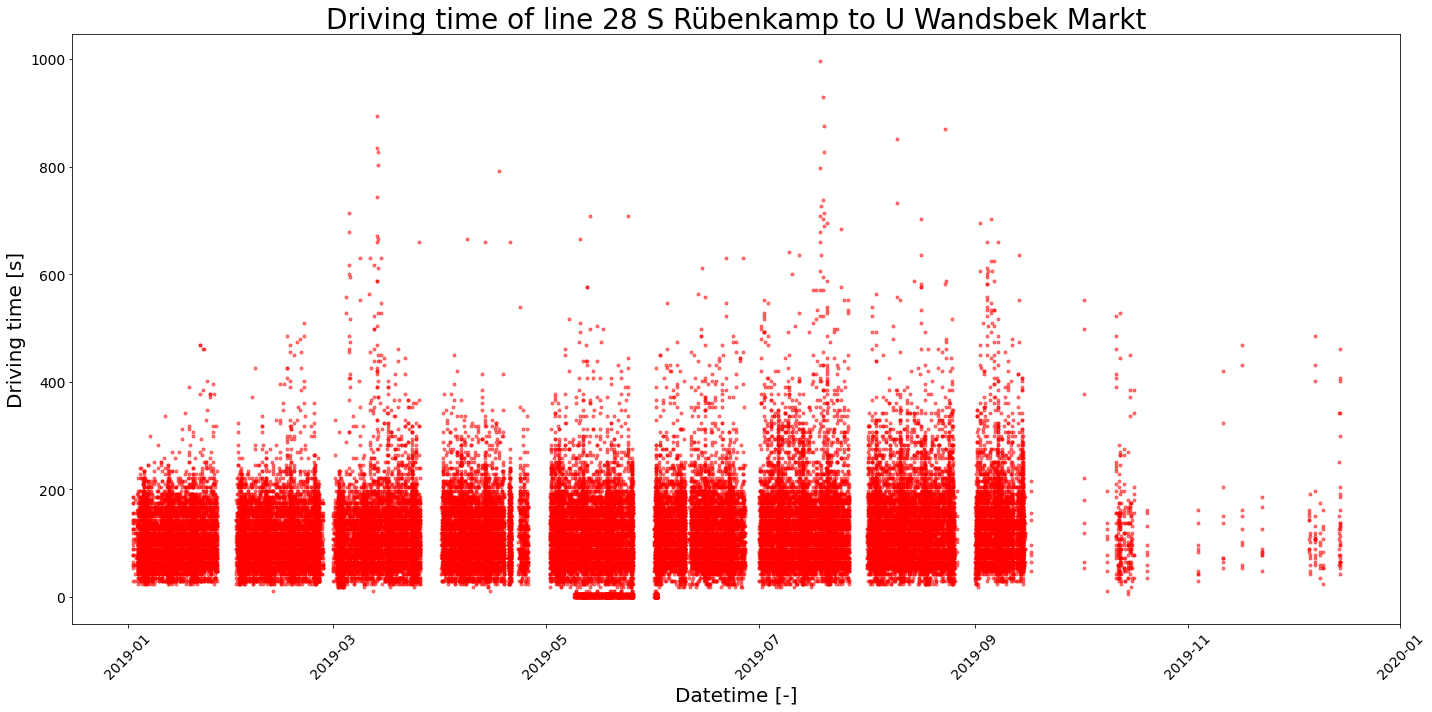

In [39]:
plt.figure(figsize=(20,10))

plt.plot(data102['Time'], data102['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time of line 28 S Rübenkamp to U Wandsbek Markt', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

**Add two new columns for accumulate values**

In [40]:
data102.loc[data102.Precipitation == -499 ]=0
data102 = data102.loc[data102['Node A to Node B'].isin(['U Straßburger Straße|Wandsbeker Allee',
'AK Barmbek|Hartzloh',
'U Habichtstraße|Habichtstraße (Mitte)',
'Habichtsplatz|U Habichtstraße',
'U Alter Teichweg|U Straßburger Straße',
'Wandsbeker Allee|U Wandsbek Markt',
'Hartzloh|Habichtsplatz',
'S Rübenkamp|AK Barmbek',
'Habichtstraße (Mitte)|U Alter Teichweg'])]

In [41]:
data102 =data102.reset_index(drop=True)

In [42]:
route_unique = (data102['Node A to Node B'].unique())
route_unique

array(['S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
       'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
       'U Habichtstraße|Habichtstraße (Mitte)',
       'Habichtstraße (Mitte)|U Alter Teichweg',
       'U Alter Teichweg|U Straßburger Straße',
       'U Straßburger Straße|Wandsbeker Allee',
       'Wandsbeker Allee|U Wandsbek Markt'], dtype=object)

In [43]:
#act_p = []
data102['Actual_trip_cum'] = 0
data102['Planned_trip_cum'] = 0
a = 0
b = 0

for i in range(len(data102)):
  #print(i)
  if data102['Node A to Node B'][i] == route_unique[0]: #the first path
    a = data102['Driving_time_s'][i]
    data102['Actual_trip_cum'][i] = a
    b = data102['Driving_time_s_p'][i]
    data102['Planned_trip_cum'][i] = b
  else:
    a += data102['Driving_time_s'][i] 
    data102['Actual_trip_cum'][i] = a
    b += data102['Driving_time_s_p'][i]
    data102['Planned_trip_cum'][i] = b
data102.tail() #[:50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/loc

,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday,Actual_trip_cum,Planned_trip_cum
62055,2019-12-14 18:21:00,U Habichtstraße|Habichtstraße (Mitte),0.0,120.0,42.0,5,12,3,462,480
62056,2019-12-14 18:23:00,Habichtstraße (Mitte)|U Alter Teichweg,0.0,180.0,132.0,5,12,3,594,660
62057,2019-12-14 18:26:00,U Alter Teichweg|U Straßburger Straße,0.0,120.0,408.0,5,12,3,1002,780
62058,2019-12-14 18:28:00,U Straßburger Straße|Wandsbeker Allee,0.0,60.0,102.0,5,12,3,1104,840
62059,2019-12-14 18:29:00,Wandsbeker Allee|U Wandsbek Markt,0.0,180.0,96.0,5,12,3,1200,1020


Save to csv

In [44]:
#data102.to_csv('ist_0420_data_processed102.csv')
#!cp ist_0420_data_processed102.csv "/content/drive/My Drive/Colab Notebooks/Thesis"
data102.to_csv('ist_01_12_19_data_processed102.csv')
!cp ist_01_12_19_data_processed102.csv "/content/drive/My Drive/Colab Notebooks/Thesis"



---



## Journey 201 ***U Wandsbek Markt to Lufthansa-Basis (Haupteingang)***

In [45]:
df_selected = df_filter.loc[df_filter['S_Station'] == 'U Wandsbek Markt'].reset_index()
df_selected = df_selected.loc[df_selected['E_Station'] == 'Lufthansa-Basis (Haupteingang)'].reset_index()
df_selected = df_selected[['Ab_ZT_PLAN', 'TagRound', 'UML', 'Linie', 'Node A to Node B', 'Precipitation', 'Driving_time_s_p', 'Driving_time_s']]
#df_selected = df_selected.loc[df_selected['UML'] == 77082]
df_selected = df_selected.loc[df_selected['Linie']  == 28].reset_index()
df_selected = df_selected.loc[(df_selected['Driving_time_s']  <= 1000) & (df_selected['Driving_time_s']  >= 0)].reset_index()
df_selected = df_selected.drop(['Linie', 'TagRound', 'index', 'UML', 'level_0'], axis=1)
df_selected= df_selected.rename({'Ab_ZT_PLAN': 'Time'}, axis=1)
df_selected

,Time,Node A to Node B,Precipitation,Driving_time_s_p,Driving_time_s
0,2019-01-02 10:57:00,U Wandsbek Markt|Wandsbeker Allee,0.0,180.0,186.0
1,2019-01-02 11:00:00,Wandsbeker Allee|U Straßburger Straße,0.0,120.0,84.0
2,2019-01-02 11:02:00,U Straßburger Straße|U Alter Teichweg,0.0,120.0,102.0
3,2019-01-02 11:04:00,U Alter Teichweg|Habichtstraße (Mitte),0.0,180.0,162.0
4,2019-01-02 11:07:00,Habichtstraße (Mitte)|U Habichtstraße,0.0,60.0,36.0
...,...,...,...,...,...
162447,2019-12-23 07:33:00,Hindenburgstraße|Brabandstraße,1.0,120.0,90.0
162448,2019-12-23 07:35:00,Brabandstraße|Moltrechtweg,1.0,60.0,66.0
162449,2019-12-23 07:36:00,Moltrechtweg|Alsterkrugchaussee (Mitte),1.0,120.0,102.0
162450,2019-12-23 07:38:00,Alsterkrugchaussee (Mitte)|Obenhauptstraße,1.0,60.0,72.0


In [46]:
import math
df_selected['dayofweek'] = df_selected['Time'].dt.dayofweek
df_selected['hour'] = (df_selected['Time'].dt.hour+1)
df_selected['day'] = df_selected['Time'].dt.day
df_selected['month'] = df_selected['Time'].dt.month
df_selected['timeofday'] = [0 for number in df_selected['Time']]
#df_selected

Filter Holidays, 19 and 22

In [47]:
#df_selected = df_selected[~df_selected['day'].isin([19,22])].reset_index()
df_selected = df_selected.loc[~(((df_selected['day'] == 1) & (df_selected['month'] ==  1))
                  |((df_selected['day'] == 19) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 21) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 22) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 1) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 30) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 10) & (df_selected['month'] == 6))
                  |((df_selected['day'] == 3) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 31) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 25) & (df_selected['month'] == 12))
                  |((df_selected['day'] == 26) & (df_selected['month'] == 12))
                  ),:].reset_index()
#df_selected[:50]

Find driving time pattern of peak hours

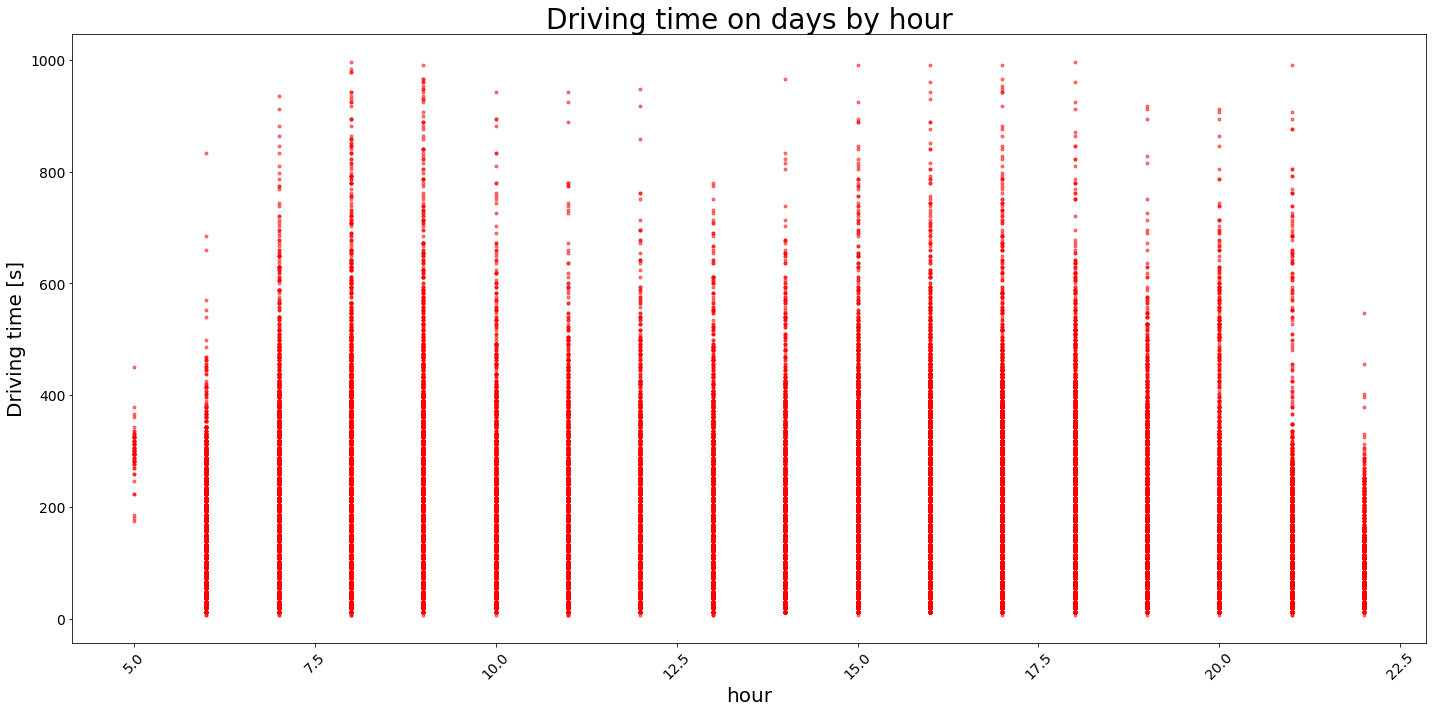

In [48]:
plt.figure(figsize=(20,10))

plt.plot(df_selected['hour'], df_selected['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('hour', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time on days by hour', fontsize=28)

plt.tight_layout()

In [49]:
for i in range(len(df_selected)):
  #print('1')
  if df_selected['hour'][i]<7:
    df_selected['timeofday'][i] = 0
  elif df_selected['hour'][i]<11:
    df_selected['timeofday'][i] = 1
  elif df_selected['hour'][i] < 15:
    df_selected['timeofday'][i] = 2
  elif df_selected['hour'][i] <19:
    df_selected['timeofday'][i] = 3
  elif df_selected['hour'][i] <22:
    df_selected['timeofday'][i] = 4
  else:
    df_selected['timeofday'][i] = 5

#df_selected


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Sett

In [50]:
df_selected = df_selected.drop(['index','day','hour'], axis=1)
#df_selected

In [51]:
len(df_selected['Node A to Node B'].unique())

58

In [52]:
df_selected.describe()

,Precipitation,Driving_time_s_p,Driving_time_s,dayofweek,month,timeofday
count,162452.000000,162452.000000,162452.000000,162452.000000,162452.000000,162452.000000
mean,-0.113486,101.865413,113.753503,2.006150,6.581107,2.134384
std,14.179904,47.026426,94.500650,1.428886,3.140865,1.226916
min,-499.000000,60.000000,6.000000,0.000000,1.000000,0.000000
25%,0.000000,60.000000,60.000000,1.000000,4.000000,1.000000
50%,0.000000,120.000000,84.000000,2.000000,7.000000,2.000000
75%,1.000000,120.000000,132.000000,3.000000,9.000000,3.000000
max,1.000000,1500.000000,996.000000,4.000000,12.000000,5.000000


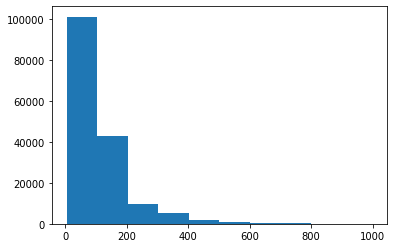

In [53]:
plt.hist(df_selected['Driving_time_s'])
plt.show()

In [54]:
data201 = df_selected.copy()

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(data201['Time'], data201['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time of line 28 U Wandsbek Markt to Lufthansa-Basis (Haupteingang)', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

**Add two new columns for accumulate values**

In [ ]:
data201.loc[data201.Precipitation == -499 ]=0
data201 = data201.loc[data201['Node A to Node B'].isin(['Kapstadtring|Manilabrücke',
'U Alsterdorf|Hindenburgstraße',
'Habichtstraße (Mitte)|U Habichtstraße',
'Neue Wöhr|Hartzloh',
'Hartzloh|AK Barmbek',
'Brabandstraße|Moltrechtweg',
'Alsterkrugchaussee (Mitte)|Obenhauptstraße',
'Manilabrücke|Sydneystraße',
'Hebebrandstraße|S Rübenkamp',
'U Habichtstraße|Habichtsplatz',
'Moltrechtweg|Alsterkrugchaussee (Mitte)',
'Hindenburgstraße|Brabandstraße',
'S Rübenkamp|Kapstadtring',
'Wandsbeker Allee|U Straßburger Straße',
'Sydneystraße|U Alsterdorf',
'Habichtsplatz|Neue Wöhr',
'AK Barmbek|Hebebrandstraße',
'U Straßburger Straße|U Alter Teichweg',
'Obenhauptstraße|Lufthansa-Basis (Haupteingang)',
'U Alter Teichweg|Habichtstraße (Mitte)',
'U Wandsbek Markt|Wandsbeker Allee',
])]

In [ ]:
data201 =data201.reset_index(drop=True)

In [ ]:
route_unique = (data201['Node A to Node B'].unique())
route_unique

In [ ]:
#act_p = []
data201['Actual_trip_cum'] = 0
data201['Planned_trip_cum'] = 0
a = 0
b = 0

for i in range(len(data201)):
  #print(i)
  if data201['Node A to Node B'][i] == route_unique[0]: #the first path
    a = data201['Driving_time_s'][i]
    data201['Actual_trip_cum'][i] = a
    b = data201['Driving_time_s_p'][i]
    data201['Planned_trip_cum'][i] = b
  else:
    a += data201['Driving_time_s'][i] 
    data201['Actual_trip_cum'][i] = a
    b += data201['Driving_time_s_p'][i]
    data201['Planned_trip_cum'][i] = b
data201.tail() #[:50]

In [ ]:
#data201.to_csv('ist_0420_data_processed201.csv')
#!cp ist_0420_data_processed201.csv "/content/drive/My Drive/Colab Notebooks/Thesis"
data201.to_csv('ist_01_12_19_data_processed201.csv')
!cp ist_01_12_19_data_processed201.csv "/content/drive/My Drive/Colab Notebooks/Thesis"



---



## Journey 202 ***Lufthansa-Basis (Haupteingang) to U Wandsbek Markt***

In [ ]:
df_selected = df_filter.loc[df_filter['S_Station'] == 'Lufthansa-Basis (Haupteingang)'].reset_index()
df_selected = df_selected.loc[df_selected['E_Station'] == 'U Wandsbek Markt'].reset_index()
df_selected = df_selected[['Ab_ZT_PLAN', 'TagRound', 'UML', 'Linie', 'Node A to Node B', 'Precipitation', 'Driving_time_s_p', 'Driving_time_s']]
#df_selected = df_selected.loc[df_selected['UML'] == 77082]
df_selected = df_selected.loc[df_selected['Linie']  == 28].reset_index()
df_selected = df_selected.loc[(df_selected['Driving_time_s']  <= 1000) & (df_selected['Driving_time_s']  >= 0)].reset_index()
df_selected = df_selected.drop(['Linie', 'TagRound', 'index', 'UML', 'level_0'], axis=1)
df_selected= df_selected.rename({'Ab_ZT_PLAN': 'Time'}, axis=1)
df_selected

In [ ]:
import math
df_selected['dayofweek'] = df_selected['Time'].dt.dayofweek
df_selected['hour'] = (df_selected['Time'].dt.hour+1)
df_selected['day'] = df_selected['Time'].dt.day
df_selected['month'] = df_selected['Time'].dt.month
df_selected['timeofday'] = [0 for number in df_selected['Time']]
#df_selected

Filter Holidays, 19 and 22

In [ ]:
#df_selected = df_selected[~df_selected['day'].isin([19,22])].reset_index()
df_selected = df_selected.loc[~(((df_selected['day'] == 1) & (df_selected['month'] ==  1))
                  |((df_selected['day'] == 19) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 21) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 22) & (df_selected['month'] == 4))
                  |((df_selected['day'] == 1) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 30) & (df_selected['month'] == 5))
                  |((df_selected['day'] == 10) & (df_selected['month'] == 6))
                  |((df_selected['day'] == 3) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 31) & (df_selected['month'] == 10))
                  |((df_selected['day'] == 25) & (df_selected['month'] == 12))
                  |((df_selected['day'] == 26) & (df_selected['month'] == 12))
                  ),:].reset_index()
#df_selected[:50]

Find peak hours pattern

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(df_selected['hour'], df_selected['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('hour', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time on days by hour', fontsize=28)

plt.tight_layout()

In [ ]:
for i in range(len(df_selected)):
  #print('1')
  if df_selected['hour'][i]<7:
    df_selected['timeofday'][i] = 0
  elif df_selected['hour'][i]<11:
    df_selected['timeofday'][i] = 1
  elif df_selected['hour'][i] < 13:
    df_selected['timeofday'][i] = 2
  elif df_selected['hour'][i] <19:
    df_selected['timeofday'][i] = 3
  elif df_selected['hour'][i] <20:
    df_selected['timeofday'][i] = 4
  else:
    df_selected['timeofday'][i] = 5

#df_selected


In [ ]:
df_selected = df_selected.drop(['index','day','hour'], axis=1)
#df_selected

In [ ]:
len(df_selected['Node A to Node B'].unique())

In [ ]:
df_selected.describe()

In [ ]:
plt.hist(df_selected['Driving_time_s'])
plt.show()

In [ ]:
data202 = df_selected.copy()

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(data202['Time'], data202['Driving_time_s'], '.', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'Driving time [s]', fontsize=20)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Driving time of line 28 Lufthansa-Basis (Haupteingang) to U Wandsbek Markt', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

**Add two new columns for accumulate values**

In [ ]:
data202.loc[data202.Precipitation == -499 ]=0
data202 = data202.loc[data202['Node A to Node B'].isin(['Lufthansa-Basis (Haupteingang)|Obenhauptstraße',
        'Obenhauptstraße|Alsterkrugchaussee (Mitte)',
        'Alsterkrugchaussee (Mitte)|Moltrechtweg',
        'Moltrechtweg|Brabandstraße', 'Brabandstraße|Hindenburgstraße',
        'Hindenburgstraße|U Alsterdorf', 'U Alsterdorf|Sydneystraße',
        'Sydneystraße|Manilabrücke', 'Manilabrücke|Kapstadtring',
        'Kapstadtring|S Rübenkamp', 'S Rübenkamp|AK Barmbek', 'AK Barmbek|Hartzloh',
        'Hartzloh|Habichtsplatz', 'Habichtsplatz|U Habichtstraße',
        'U Habichtstraße|Habichtstraße (Mitte)',
        'Habichtstraße (Mitte)|U Alter Teichweg',
        'U Alter Teichweg|U Straßburger Straße',
        'U Straßburger Straße|Wandsbeker Allee',
        'Wandsbeker Allee|U Wandsbek Markt'])]

In [ ]:
data202 =data202.reset_index(drop=True)

In [ ]:
route_unique = (data202['Node A to Node B'].unique())
route_unique

In [ ]:
#act_p = []
data202['Actual_trip_cum'] = 0
data202['Planned_trip_cum'] = 0
a = 0
b = 0

for i in range(len(data202)):
  #print(i)
  if data202['Node A to Node B'][i] == route_unique[0]: #the first path
    a = data202['Driving_time_s'][i]
    data202['Actual_trip_cum'][i] = a
    b = data202['Driving_time_s_p'][i]
    data202['Planned_trip_cum'][i] = b
  else:
    a += data202['Driving_time_s'][i] 
    data202['Actual_trip_cum'][i] = a
    b += data202['Driving_time_s_p'][i]
    data202['Planned_trip_cum'][i] = b
data202.tail() #[:50]

In [76]:
#data202.to_csv('ist_0420_data_processed202.csv')
#!cp ist_0420_data_processed202.csv "/content/drive/My Drive/Colab Notebooks/Thesis"
data202.to_csv('ist_01_12_19_data_processed202.csv')
!cp ist_01_12_19_data_processed202.csv "/content/drive/My Drive/Colab Notebooks/Thesis"